In [1]:
##First we load the libraries need
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub

In [20]:
#Load the dataset from the tensorflow_datasets library with the info
#I also split the data and load the train and test data seperatly
train, info = tfds.load('tf_flowers', split='train[80%:]', with_info=True, as_supervised=True)
test = tfds.load('tf_flowers', split='train[:80%]', with_info=False, as_supervised=True)

In [56]:
#here we can see the classes in our data which is the kind of flowers in our dataset which as can be seen are 5 different flowers
classes = info.features['label'].names
classes

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [45]:
#Iterating over the data points to put them in a list for manalysing and vizualising the data
images =[]
labels= []
for example, label in train:
    images.append(example)
    labels.append(label)
for example, label in test:
    images.append(example)
    labels.append(label)

In [5]:
labels= np.array(labels)
labels_df=pd.DataFrame(labels, columns=["Flowers Labels"])
labels_df.head()

,Flowers Labels
0,4
1,2
2,2
3,2
4,1


In [6]:
labels_df['Flowers Labels'].value_counts()

0    898
2    799
3    699
4    641
1    633
Name: Flowers Labels, dtype: int64

In [7]:
#According to the the info of the dataset the labels belong to the classes as dispalyed below
labels_df["Flowers Labels"][labels_df["Flowers Labels"]==0]='dandelion'
labels_df["Flowers Labels"][labels_df["Flowers Labels"]==1]='daisy'
labels_df["Flowers Labels"][labels_df["Flowers Labels"]==2]= 'tulips'
labels_df["Flowers Labels"][labels_df["Flowers Labels"]==3]='sunflowers'
labels_df["Flowers Labels"][labels_df["Flowers Labels"]==4]='roses'

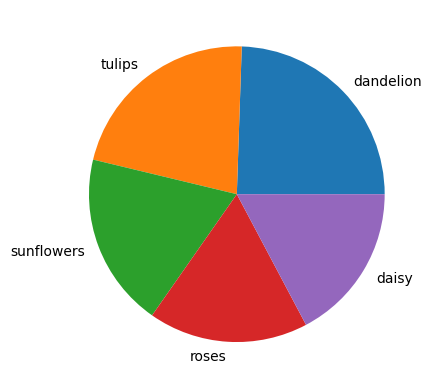

In [8]:
vc= labels_df['Flowers Labels'].value_counts()
plt.pie(vc.values, labels=vc.index);

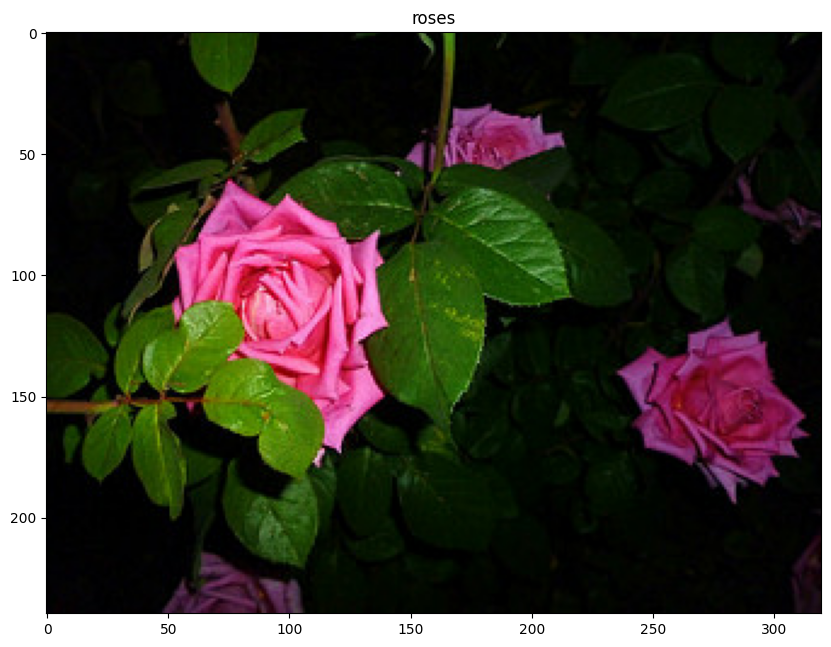

4


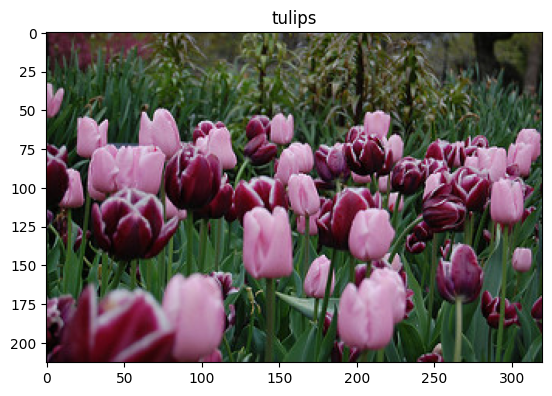

2


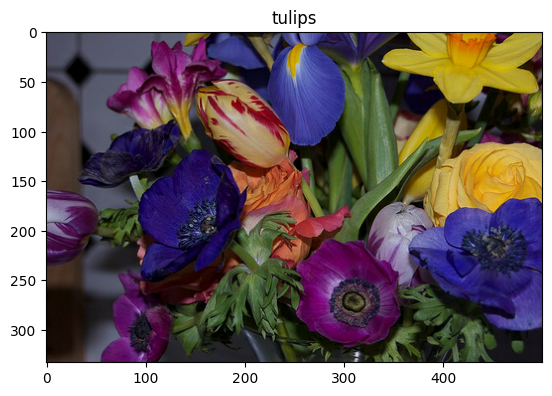

2


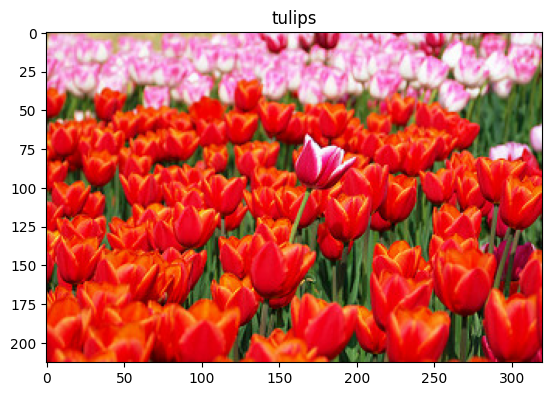

2


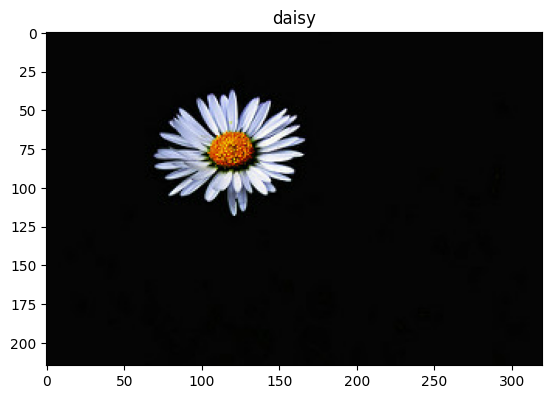

1


In [9]:
plt.figure(figsize=(10, 10))
for i in range (5):
  img=images[i]
  label=labels[i]
  plt.imshow(img)
  plt.title(classes[labels[i]])
  plt.show()
  print(label)

In [12]:
num_images=0
for example in train:
    num_images += 1

In [14]:
#We write the "resize" function to turn all the pixels between 0 and one an dturn the images to the appropriat size to make it easier for processing
def resize(image, label):
    image = tf.image.resize(image, (224, 224))/255.0
    return image, label

In [21]:
#Applying the resize function, shuffling and batching the data
train = train.shuffle(num_images//4).map(resize).batch(32).prefetch(1)
test = test.map(resize).batch(32).prefetch(1)

In [31]:
#For the model I am using a pretrained model wieghts from keras hub
#The pretrained model is the famous mobilenet model
pretrained = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", input_shape=(224, 224, 3))
pretrained.trainable = False
model = tf.keras.Sequential([
  pretrained,
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dense(64),
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(5)
])

In [32]:
model.compile( optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
history= model.fit(train, epochs=15)

Epoch 1/15
23/23 [==============================] - 33s 1s/step - loss: 1.9782 - accuracy: 0.5177 - top_k_categorical_accuracy: 0.5450
Epoch 2/15
23/23 [==============================] - 27s 1s/step - loss: 0.9282 - accuracy: 0.7357 - top_k_categorical_accuracy: 0.4918
Epoch 3/15
23/23 [==============================] - 27s 1s/step - loss: 0.5016 - accuracy: 0.8338 - top_k_categorical_accuracy: 0.5218
Epoch 4/15
23/23 [==============================] - 28s 1s/step - loss: 0.4858 - accuracy: 0.8270 - top_k_categorical_accuracy: 0.5300
Epoch 5/15
23/23 [==============================] - 27s 1s/step - loss: 0.4114 - accuracy: 0.8719 - top_k_categorical_accuracy: 0.5708
Epoch 6/15
23/23 [==============================] - 27s 1s/step - loss: 0.3211 - accuracy: 0.8951 - top_k_categorical_accuracy: 0.5899
Epoch 7/15
23/23 [==============================] - 28s 1s/step - loss: 0.2959 - accuracy: 0.8924 - top_k_categorical_accuracy: 0.5490
Epoch 8/15
23/23 [==============================] - 26s

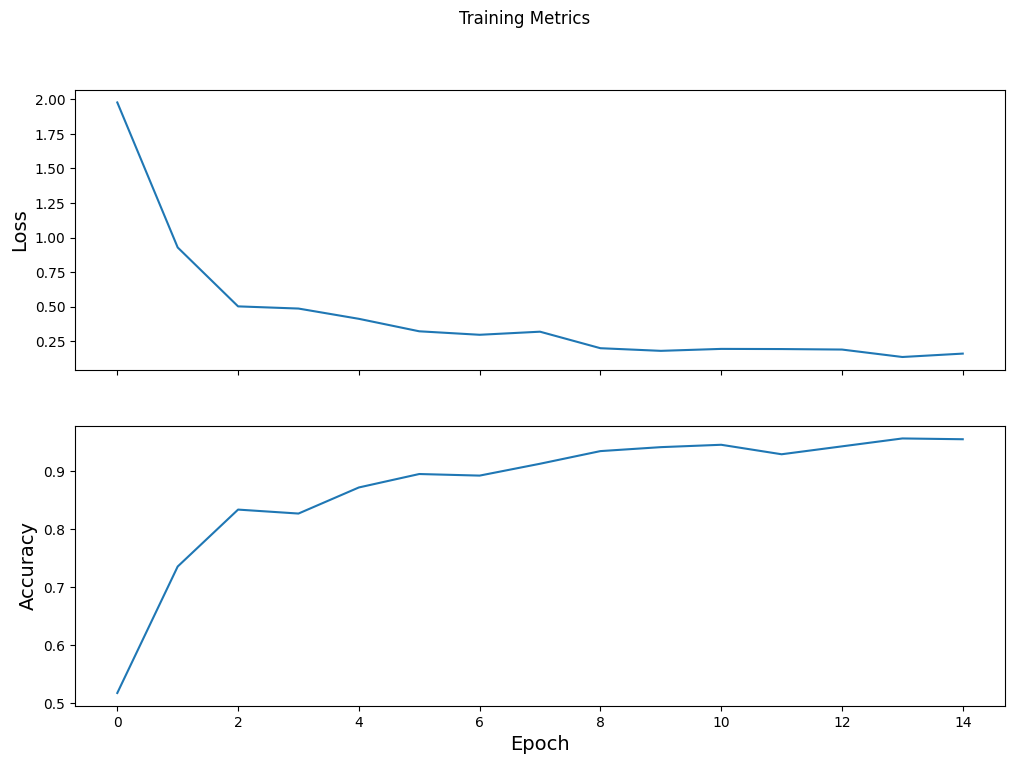

In [33]:
#With the plot below we can see our models evoulution epoch by epoch on the loss and accuracy metric
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')
history_dict = history.history
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(history_dict['loss'])

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(history_dict['accuracy'])
plt.show()

In [34]:
#Now we evaluate our model on the holdout test set to see if there has been a case of overfitting
model.evaluate(test)

92/92 [==============================] - 108s 1s/step - loss: 0.6734 - accuracy: 0.8624 - top_k_categorical_accuracy: 0.4775


[0.6733700037002563, 0.8623978495597839, 0.4775204360485077]

In [53]:
#Here, we creat a numpy list from the names of the flowers so we can draw a plot and check our model's perfomance with images
class_names = np.array(info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


1/1 [==============================] - 2s 2s/step


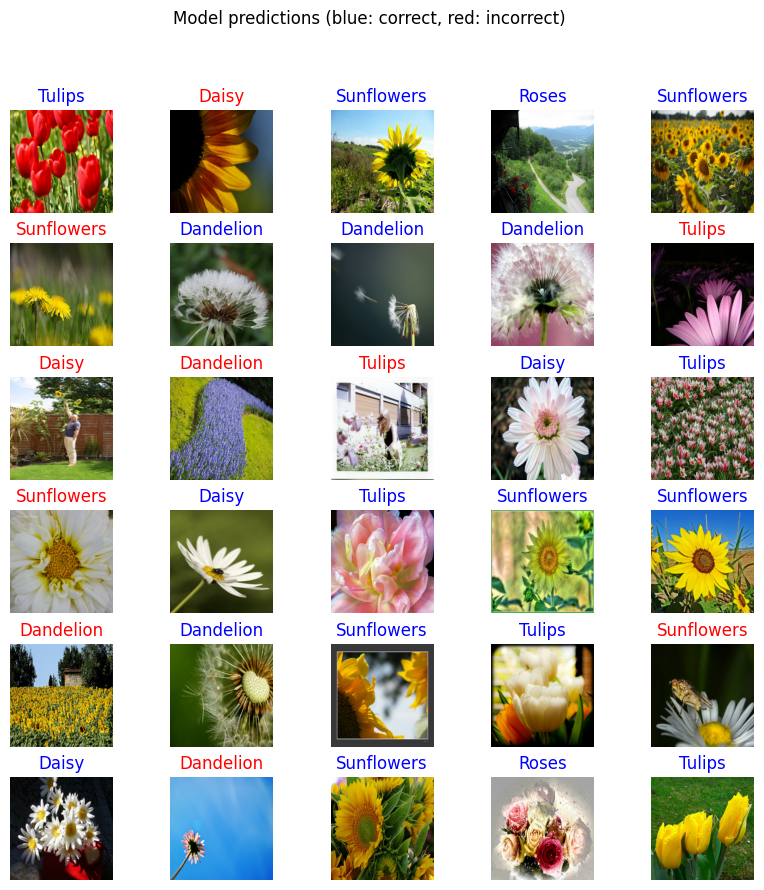

In [55]:
#With this code we can see which images the model got right and on what images it made mistake
#All these images are from the holdout test set
#If the model's prediction is correct then the label will apear blue and if the model has made a mistake regarding the label of that image then the label for the that image will appear red
image_batch, label_batch = next(iter(test))
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")